In [1]:
import tensorflow as tf
from functools import partial
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape
from alibi_detect.cd.tensorflow import preprocess_drift
from tensorflow.keras import layers
from alibi_detect.cd import KSDrift
import numpy as np
import methods
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
import pandas as pd
from pathlib import Path
from ood_metrics import calc_metrics, plot_roc, plot_pr, plot_barcode

import logging 
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# Assume that you have 12GB of GPU memory and want to allocate ~4GB:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.1)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Num GPUs Available:  1


In [2]:
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms.functional as F
import torch
%matplotlib inline
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [4]:
inlier_names = ["cCry", "sCry", "uCry", "hCast", "nhCast", "nsEC", "sEC", "WBC", "RBC", "Artifact", "Dirt", "LD"]
testImages_cCry = methods.getTestRawImages("cCry", (32,32))
testImages_sCry = methods.getTestRawImages("sCry", (32,32))
testImages_uCry = methods.getTestRawImages("uCry", (32,32))
testImages_hCast = methods.getTestRawImages("hCast", (32,32))
testImages_nhCast = methods.getTestRawImages("nhCast", (32,32))
testImages_nsEC = methods.getTestRawImages("nsEC", (32,32))
testImages_sEC = methods.getTestRawImages("sEC", (32,32))
testImages_WBC = methods.getTestRawImages("WBC", (32,32))
testImages_RBC = methods.getTestRawImages("RBC", (32,32))
testImages_Artifact = methods.getTestRawImages("Artifact", (32,32))
testImages_Dirt = methods.getTestRawImages("Dirt", (32,32))
testImages_LD = methods.getTestRawImages("LD", (32,32))

X_inliers = np.concatenate((testImages_cCry, testImages_sCry, testImages_uCry, testImages_hCast, testImages_nhCast, testImages_nsEC,
                       testImages_sEC, testImages_WBC, testImages_RBC))
unclassified_imgs = methods.getTestRawImages("Unclassified", (32,32))

In [5]:
encoder_net = keras.models.load_model('vae_encoder_net', compile=False)
decoder_net = keras.models.load_model('vae_decoder_net', compile=False)

In [6]:
def getPermuteOutputs(encoder, X):
    outputs = []
    for x in X:
        outputs.append(encoder.predict(x.reshape(1, 32, 32, 1)))  
    return np.asarray(outputs).reshape(-1, 256)

In [17]:
def test_ksd(cd, imgs_ref, imgs, label):
    p_vals = []
    distances = []
    labels = []
    imgs_array = []
    for img in imgs:
        p_val, dist = cd.feature_score(x_ref=imgs_ref, x=img.reshape(-1,32, 32, 1))
        p_vals.append(np.mean(p_val))
        distances.append(np.mean(dist))
        labels.append(label)
        imgs_array.append(img)
    d = {"p_vals": p_vals, "distances": distances, "labels": labels, "imgs_array": imgs_array}

    df = pd.DataFrame(data=d)
    return df

def test_ksd_final(cd, encoder, imgs_ref, perturb = None, y_limit = None):
    inlier_scores = []
    inlier_labels = []
    outlier_scores = []
    outlier_labels = []
    inlier_path = "/home/erdem/dataset/urine_test_32/inliers"
    outlier_path = "/home/erdem/dataset/urine_test_32/outliers"
    # Inliers
    for img_path in Path(inlier_path).glob("*.png"):
        inlier_labels.append(0)
        image = plt.imread(img_path)
        if perturb == 'gaussian':
            image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
        elif perturb == 's&p':
            image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, amount=0.03, clip=True))
        output = encoder.predict(image.reshape(1, 32, 32, 1))
        _, dist = cd.feature_score(x_ref=imgs_ref, x=output[2].reshape(1, 256))
        temp_score = np.amax(np.mean(dist))
        inlier_scores.append(temp_score)
    
    # Outliers
    for img_path in Path(outlier_path).glob("*.png"):
        outlier_labels.append(1)
        image = plt.imread(img_path)
        if perturb == 'gaussian':
            image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
        elif perturb == 's&p':
            image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, amount=0.03, clip=True))
        output = encoder.predict(image.reshape(1, 32, 32, 1))
        _, dist = cd.feature_score(x_ref=imgs_ref, x=output[2].reshape(1, 256))
        temp_score = np.amax(np.mean(dist))
        outlier_scores.append(temp_score)
    
    d_outliers = {"K-S Distance": outlier_scores, "outlier_labels": outlier_labels, "Index of Image Patches": np.linspace(1, 636, num=636)}
    d_inliers = {"K-S Distance": inlier_scores, "inlier_labels": inlier_labels, "Index of Image Patches": np.linspace(1, 636, num=636)}
    df1 = pd.DataFrame(data=d_inliers)
    df2 = pd.DataFrame(data=d_outliers)
    g = sns.scatterplot(data=df1, x="Index of Image Patches", y="K-S Distance")
    g = sns.scatterplot(data=df2, x="Index of Image Patches", y="K-S Distance")
    g.set(ylim=(0, y_limit))
    score_array = inlier_scores+outlier_scores
    label_array = inlier_labels+outlier_labels

    print(calc_metrics(score_array, label_array))

    plot_roc(score_array, label_array)
    plot_pr(score_array, label_array)
#     plot_barcode(score_array, label_array)

In [13]:
inlier_outputs = getPermuteOutputs(encoder_net, X_inliers)

In [14]:
inlier_outputs.shape

(23895, 256)

In [15]:
cd = KSDrift(inlier_outputs, p_val=.05, correction = 'fdr', preprocess_x_ref=False)

{'fpr_at_95_tpr': 0.9386792452830188, 'detection_error': 0.49292452830188677, 'auroc': 0.527036114077766, 'aupr_out': 0.5327169003875674, 'aupr_in': 0.5229731490386684}


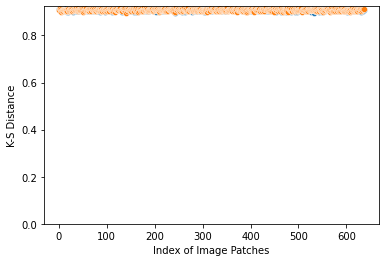

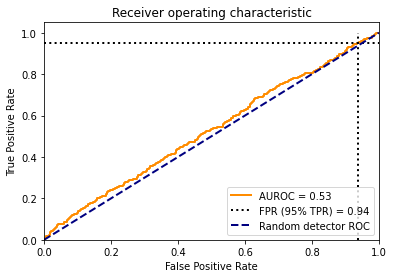

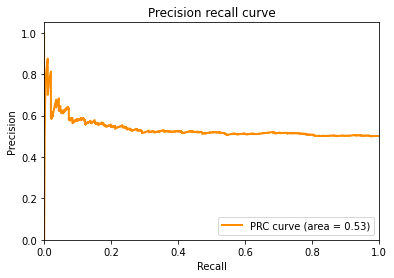

In [18]:
test_ksd_final(cd, encoder_net, inlier_outputs, perturb = None, y_limit = None)

{'fpr_at_95_tpr': 0.3867924528301887, 'detection_error': 0.21776729559748428, 'auroc': 0.8898147324077371, 'aupr_out': 0.8818324040804865, 'aupr_in': 0.8930800624551836}


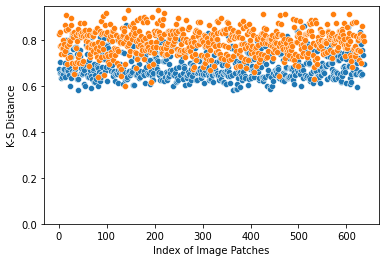

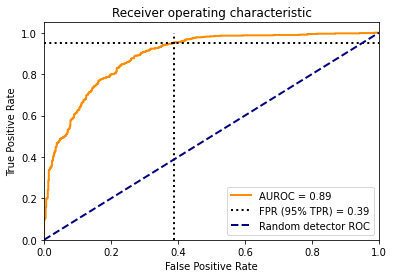

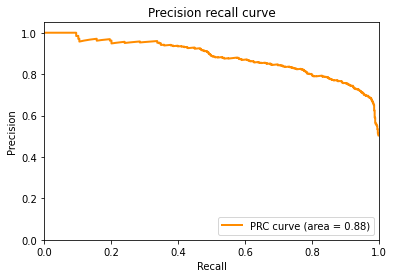

In [10]:
test_ksd_final(cd, encoder_net, inlier_outputs, perturb = None, y_limit = None)

{'fpr_at_95_tpr': 0.36477987421383645, 'detection_error': 0.20597484276729558, 'auroc': 0.894458783275978, 'aupr_out': 0.8790701714030573, 'aupr_in': 0.8998199459038005}


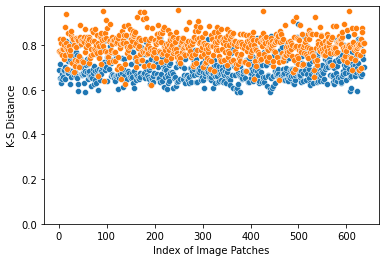

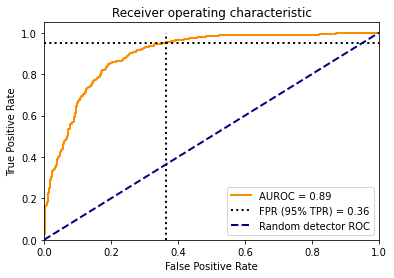

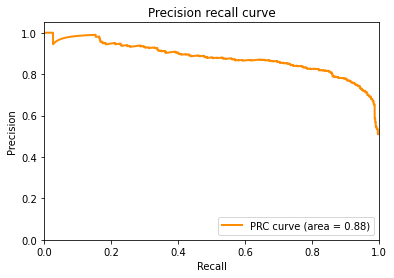

In [37]:
test_ksd_final(cd, encoder_net, inlier_outputs, perturb = None, y_limit = None)

<AxesSubplot:xlabel='outlier_labels', ylabel='outlier_scores'>

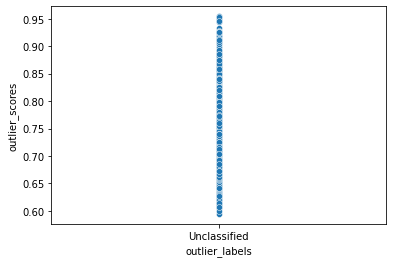

In [44]:
cl_path = "/home/thomas/tmp/patches_urine_32_scaled/Unclassified"
perturb = None
outlier_labels = []
outlier_scores = []
outlier_path = []
cl = "Unclassified"  
for img_path in Path(cl_path).glob("*.png"):
    outlier_path.append(img_path)
    outlier_labels.append(cl)
    image = plt.imread(img_path)
    if perturb == 'gaussian':
        image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
    elif perturb == 's&p':
        image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, clip=True))
    output = encoder_net.predict(image.reshape(1, 32, 32, 1))
    _, dist = cd.feature_score(x_ref=inlier_outputs, x=output.reshape(1, 256))
    temp_score = np.amax(np.mean(dist))
    outlier_scores.append(temp_score)
    
d = {"outlier_scores": outlier_scores, "outlier_labels": outlier_labels, "outlier_path": outlier_path}

df3 = pd.DataFrame(data=d)
sns.scatterplot(data=df3, x = "outlier_labels", y="outlier_scores")

In [45]:
sorted_unclassified = df3.sort_values(by=['outlier_scores'])
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms.functional as F
%matplotlib inline
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
unclassified_imgs = []
for path in sorted_unclassified["outlier_path"]:
    unclassified_imgs.append(read_image(str(path)))

In [40]:
# Random encoder_net
encoding_dim = 256

encoder_net2 = tf.keras.Sequential(
[
    layers.InputLayer(input_shape=(32,32, 1)),
    layers.Conv2D(64, (4,4), strides=2, padding='same', activation=tf.nn.relu),
    layers.Conv2D(64, (4,4), strides=2, padding='same', activation=tf.nn.relu),
    layers.Conv2D(64, (4,4), strides=2, padding='same', activation=tf.nn.relu),
    layers.Conv2D(64, (4,4), strides=2, padding='same', activation=tf.nn.relu),
    layers.Flatten(),
    layers.Dense(encoding_dim,)
])
encoder_net2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        1088      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          65600     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          65600     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 64)          65600     
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
Total params: 263,680
Trainable params: 263,680
Non-trainable params: 0
__________________________________________________

{'fpr_at_95_tpr': 1.0, 'detection_error': 0.5, 'auroc': 0.477481853961473, 'aupr_out': 0.5841484346982612, 'aupr_in': 0.44426038904723114}


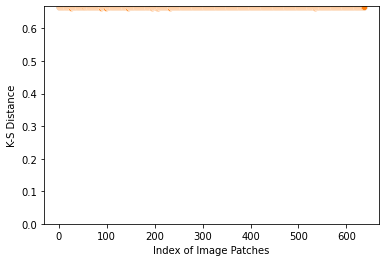

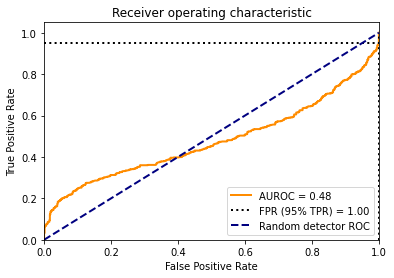

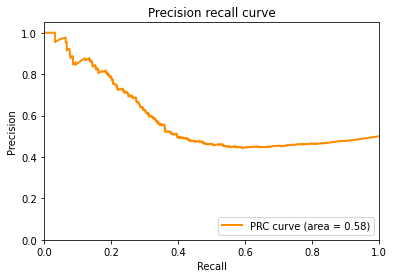

In [41]:
test_ksd_final(cd, encoder_net2, inlier_outputs, perturb = None, y_limit = None)

<AxesSubplot:xlabel='outlier_labels', ylabel='outlier_scores'>

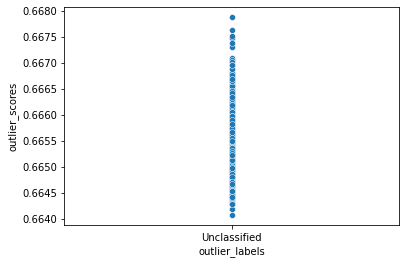

In [48]:
cl_path = "/home/thomas/tmp/patches_urine_32_scaled/Unclassified"
perturb = None
outlier_labels = []
outlier_scores = []
outlier_path = []
cl = "Unclassified"  
for img_path in Path(cl_path).glob("*.png"):
    outlier_path.append(img_path)
    outlier_labels.append(cl)
    image = plt.imread(img_path)
    if perturb == 'gaussian':
        image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
    elif perturb == 's&p':
        image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, clip=True))
    output = encoder_net2.predict(image.reshape(1, 32, 32, 1))
    _, dist = cd.feature_score(x_ref=inlier_outputs, x=output.reshape(1, 256))
    temp_score = np.amax(np.mean(dist))
    outlier_scores.append(temp_score)
    
d = {"outlier_scores": outlier_scores, "outlier_labels": outlier_labels, "outlier_path": outlier_path}

df3 = pd.DataFrame(data=d)
sns.scatterplot(data=df3, x = "outlier_labels", y="outlier_scores")

In [49]:
sorted_unclassified = df3.sort_values(by=['outlier_scores'])
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms.functional as F
%matplotlib inline
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
unclassified_imgs = []
for path in sorted_unclassified["outlier_path"]:
    unclassified_imgs.append(read_image(str(path)))

In [6]:
df_unclassified = test_ksd(cd, X_inliers, unclassified_imgs, 0)
sorted_p_vals = df_unclassified.sort_values(by=['p_vals'])